# 02 Отладка алгоритмов многоруких бандитов

## Моделирование методом Монте-Карло - это как модульные тесты для алгоритмов Бандита

Несмотря на то, что в ранее была приведена полная реализация алгоритма epsilon-Greedy, это все равно было очень абстрактное обсуждение, поскольку алгоритм так и не был запущен. Причина этого проста: в отличие от стандартных инструментов машинного обучения, алгоритмы бандитов - это не просто функции "черного ящика", которые можно вызвать для обработки имеющихся у вас данных, - алгоритмы бандитов должны активно выбирать, какие данные следует получить, и анализировать их в режиме реального времени. 

Действительно, алгоритмы бандитов являются примером двух типов обучения, которые отсутствуют в стандартных примерах ML: активного обучения, которое относится к алгоритмам, активно выбирающим данные, которые они должны получить; и онлайн-обучения, которое относится к алгоритмам, анализирующим данные в режиме реального времени и предоставляющим результаты на лету.

Это означает, что в каждом бандитском алгоритме существует сложный цикл обратной связи: как показано на рисунке, поведение алгоритма зависит от данных, которые он видит, а данные, которые видит алгоритм, зависят от поведения алгоритма. Поэтому отладка бандитского алгоритма значительно сложнее, чем отладка обычного алгоритма машинного обучения, который не занимается активным обучением. Вы не можете просто скормить алгоритму-бандиту данные: вам нужно где-то запустить его, чтобы посмотреть, как он может вести себя в производстве. 

Конечно, делать это на собственном сайте может быть очень рискованно: вы же не хотите выкладывать непроверенный код на живой сайт.

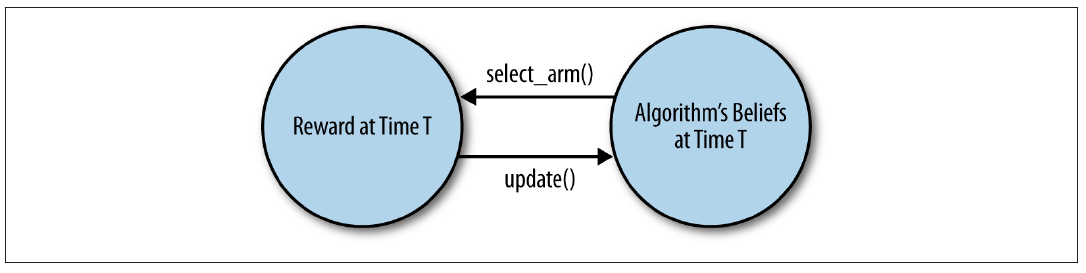

Чтобы решить обе эти проблемы, мы воспользуемся альтернативой стандартному юнит-тестированию, которая подходит для тестирования бандитских алгоритмов. Эта альтернатива называется симуляцией Монте-Карло. Название пошло со времен Второй мировой войны, когда ученые проверяли, как может повести себя оружие и другие системы, используя простые компьютеры, оснащенные генератором случайных чисел.

Для наших целей симуляция Монте-Карло позволит нашей реализации алгоритма бандита активно принимать решения о том, какие данные ей получать, поскольку наши симуляции смогут предоставлять алгоритму для анализа симулированные данные в режиме реального времени. Короче говоря, мы будем работать с циклом обратной связи, показанным ранее, кодируя как наш алгоритм бандита, так и симуляцию рук бандита, между которыми алгоритм должен выбирать. Затем эти две части кода работают вместе, чтобы создать пример того, как алгоритм может функционировать в реальности.

Поскольку в каждой симуляции используются случайные числа, результаты получаются шумными. По этой причине вам потребуется провести множество симуляций. К счастью, современные компьютеры, в отличие от тех, что использовались во время Второй мировой войны, вполне справляются с этой задачей. Как вы увидите через некоторое время, мы можем легко смоделировать 100 000 запусков алгоритма бандита, чтобы развить интуицию относительно его поведения в различных условиях. Это, пожалуй, гораздо важнее, чем понимание конкретного алгоритма бандита.

## Симулирование рук бандита

Чтобы разумно смоделировать, что может произойти, если вы развернете алгоритм epsilon- Greedy в производстве, нам нужно создать несколько гипотетических рук. Мы сосредоточимся на очень простом типе симулятора, который легко реализовать правильно. Этот гипотетический манипулятор позволит нам смоделировать такие параметры, как:

- **Оптимизация количества кликов по объявлениям**: Каждый раз, когда мы показываем кому-то рекламу, мы представляем, что существует фиксированная вероятность того, что он нажмет на объявление. Бандитский алгоритм оценивает эту вероятность и пытается выбрать стратегию показа объявлений, которая максимизирует количество кликов.

- **Конверсия для новых пользователей**: Каждый раз, когда на наш сайт приходит новый посетитель, который еще не зарегистрирован, мы будем представлять, что существует фиксированная вероятность того, что он зарегистрируется как пользователь после просмотра целевой страницы. Затем мы оценим эту вероятность и попытаемся выбрать стратегию для максимизации конверсии.

Наша симулируемая рука будет называться рукой Бернулли. 

Называя этот тип руки рукой Бернулли, мы просто говорим на жаргоне, что имеем дело с рукой, которая в определенном проценте случаев вознаграждает вас значением 1, а в остальное время - значением 0. Эта схема 0/1 - очень простой способ моделирования таких ситуаций, как клики или регистрация пользователей: потенциальный пользователь приходит на ваш сайт; вы выбираете для него руку, в которой вы, например, показываете ему логотип определенного цвета; в конце концов, он либо регистрируется на сайте (и получает вознаграждение 1), либо нет (и получает вознаграждение 0). 

Если 2 % людей, увидевших красный логотип, подписываются, а 5 % людей, увидевших зеленый логотип, подписываются, то можно абстрагироваться от деталей и говорить о двух руках: одна рука выдает 1 единицу вознаграждения в 2 % случаев, другая рука выдает 1 единицу вознаграждения в 5 % случаев. Такую ситуацию мы называем "рука Бернулли". 

Мы реализуем ее на языке Python следующим образом:

```python
class BernoulliArm:
    def __init__(self, p):
        self.p = p
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0
```

Во-первых, есть класс BernoulliArm с единственным полем p, которое говорит нам о вероятности получить награду в 1 единицу от этой руки. Во-вторых, есть метод draw, который при вызове выдает 1 единицу вознаграждения с вероятностью p. Вот и весь наш абстрактный способ думать о кликах и так далее. Удивительно, но это дает достаточно материала для очень мощной системы моделирования.

Единственное, чего не хватает в этом подходе, так это того, что нам обычно приходится работать с большим количеством рук, поэтому нам нужно будет создать массив объектов Arm. Например, мы можем сделать следующее:

```python
means = [0.1, 0.1, 0.1, 0.1, 0.9]
n_arms = len(means)
random.shuffle(means)
arms = map(lambda (mu): BernoulliArm(mu), means)
```

Это создаст массив, содержащий 5 рук. 4 из них выдают вознаграждение в 10 % случаев, а лучшая из них выдает вознаграждение в 90 % случаев. Это очень черно-белая ситуация, которую вы не увидите в реальном мире, но это означает, что она является хорошей отправной точкой для тестирования наших алгоритмов.

Чтобы испытать наше руки Бернулли, можно вызвать команду draw несколько раз на некоторых элементах нашего массива следующим образом:

In [1]:
import random

class BernoulliArm:
    def __init__(self, p):
        self.p = p
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

means = [0.1, 0.12, 0.15]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))

In [2]:
arms

In [3]:
print(arms[0].draw())
print(arms[1].draw())
print(arms[2].draw())

0.0
0.0
0.0


Теперь мы почти готовы начать экспериментировать с алгоритмом epsilon-Greedy. Но перед этим мы создадим очень общий фреймворк для тестирования алгоритма. Этот фреймворк полностью описывается функцией test_algorithm, показанной ниже, и будет единственным инструментом тестирования, необходимым до конца этой книги. Давайте пройдемся по нему сейчас:

In [4]:
def test_algorithm(algo, arms, num_sims, horizon):
    '''
    algo:
    arms:
    num_sims:
    horizon:
    '''
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]

    for sim in range(num_sims):
        sim = sim + 1
        algo.initialize(len(arms))

        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t - 1
            sim_nums[index] = sim
            times[index] = t

            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm

            reward = arms[chosen_arms[index]].draw()
            rewards[index] = reward

            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index - 1] + reward

            algo.update(chosen_arm, reward)

    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

Как работает этот фреймворк? 

- Мы передаем несколько объектов: 
    - алгоритм бандита, который мы хотим протестировать; 
    - массив рук, из которых мы хотим смоделировать розыгрыши; 
    - фиксированное количество симуляций для усреднения шума в каждой симуляции; 
    - количество раз, которое каждому алгоритму разрешено перебирать руки во время каждой симуляции. Любой не самый плохой алгоритм в конце концов узнает, какая рука лучше; интереснее всего изучить в симуляции, хорошо ли работает алгоритм, когда у него есть всего 100 (или 100 000) попыток найти лучшую руку.
- Затем фреймворк использует эти объекты для проведения множества независимых симуляций. Для каждой из них он:
    - Инициализирует настройки алгоритма бандита с нуля, чтобы у него не было предварительных знаний о том, какая рука лучше. 
    - Перебирает возможности потянуть руку. На каждом шаге этого цикла он: 
        - Вызывает select_arm, чтобы увидеть, какую руку выберет алгоритм; 
        - Вызывает draw на этой руке, чтобы смоделировать результат вытягивания этой руки; 
        - Записывает сумму вознаграждения, полученную алгоритмом, а затем вызывает update, чтобы позволить алгоритму обработать эту новую часть информации.
        
- Наконец, система тестирования возвращает набор данных, который сообщает нам для каждой симуляции, какая рука была выбрана и насколько хорошо работал алгоритм в каждый момент времени.

Чтобы показать вам, как использовать этот фреймворк для тестирования, нам нужно передать конкретный алгоритм и конкретный набор рук. В приведенном ниже коде мы покажем, что происходит при применении алгоритма epsilon-Greedy, который мы реализовали ранее, к пяти плечам Бернулли, которые мы определили минуту назад. Для простоты мы воспроизвели весь необходимый код ниже, включая переопределение пяти рук Бернулли:

In [5]:
import random

def ind_max(x):
    m = max(x)
    return x.index(m)

class EpsilonGreedy:
    def __init__(self, epsilon, counts, values):
        self.epsilon = epsilon
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]

    def select_arm(self):
        if random.random() > self.epsilon:
            return ind_max(self.values)
        else:
            return random.randrange(len(self.values))
  
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value
        
class BernoulliArm:
    def __init__(self, p):
        self.p = p
    def draw(self):
        if random.random() > self.p:
            return 0.0
        else:
            return 1.0

In [6]:
random.seed(1)
means = [0.1, 0.12, 0.15]
n_arms = len(means)
random.shuffle(means)

In [7]:
means

[0.12, 0.15, 0.1]

In [8]:
random.seed(1)
means = [0.1, 0.12, 0.15]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(ind_max(means)))

f = open("standard_results.tsv", "w")

for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
    algo = EpsilonGreedy(epsilon, [], [])
    algo.initialize(n_arms)
    
    results = test_algorithm(
        algo=algo, 
        arms=arms, 
        num_sims=5000, 
        horizon=250)
    
    for i in range(len(results[0])):
        f.write(str(epsilon) + "\t")
        f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")
f.close()

Best arm is 1


In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('standard_results.tsv', sep='\t', header=None)
df.columns = ['epsilon', 'sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards']

In [11]:
df['chosen_arms'][(df['epsilon'] == 0.1)&(df['sim_nums'] == 1)].value_counts()

chosen_arms
1    164
0     71
2     15
Name: count, dtype: int64

# Анализ результатов исследования методом Монте-Карло

Имея на руках результаты симуляционного исследования, мы можем проанализировать наши данные несколькими различными способами, чтобы оценить эффективность наших алгоритмов..

## Подход 1: отслеживание вероятности выбора лучшей руки

Первый аналитический подход, и, конечно, самый простой, заключается в отслеживании вероятности того, что что наш алгоритм выбирает лучшую руку в любой момент времени.

Нам нужно работать с коэффициентами по двум разным причинам: (1) алгоритм использует случайность при выборе руки, которую нужно тянуть, и поэтому может не выбрать лучшую руку даже после того, как узнает, какая рука лучше, и (2) вознаграждения, которые получает алгоритм, тоже случайны. По этим причинам всегда есть вероятность того, что алгоритм не примет наилучшего решения в каждом конкретном испытании.

Поэтому мы явно рассчитаем вероятность выбора лучшей руки, оценив процент случаев, когда алгоритм выбирал лучшую руку в наших симуляциях. Если вероятность того, что алгоритм выберет лучшую руку, не увеличивается с течением времени, то у нас у нас нет никаких доказательств того, что наш алгоритм узнает что-то о значениях руки. К счастью, результаты, показанные на рисунке 4-2, где данные разделены по эпсилон, показывают, что наш алгоритм действительно учится, независимо от того, как мы задаем значение
epsilon.

In [12]:
import matplotlib.pyplot as plt

In [13]:
kk = df[(df['chosen_arms']==1)].groupby(['epsilon', 'times', 'chosen_arms']).size().reset_index()
kk.columns = ['epsilon', 'times', 'chosen_arms', 'count']
kk['proba'] = kk['count']/5000

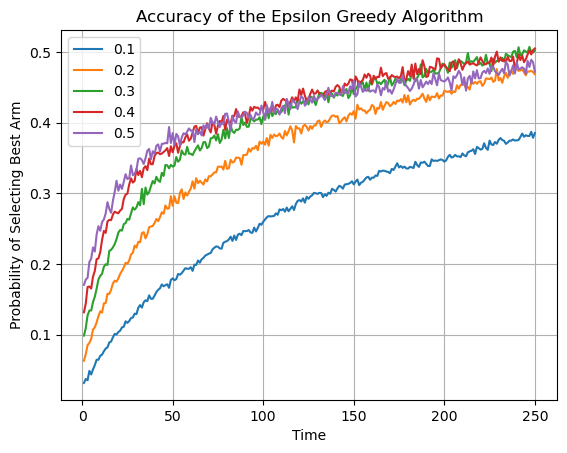

In [14]:
plt.plot(kk['times'][kk['epsilon'] == 0.1], kk['proba'][kk['epsilon'] == 0.1], label='0.1')
plt.plot(kk['times'][kk['epsilon'] == 0.2], kk['proba'][kk['epsilon'] == 0.2], label='0.2')
plt.plot(kk['times'][kk['epsilon'] == 0.3], kk['proba'][kk['epsilon'] == 0.3], label='0.3')
plt.plot(kk['times'][kk['epsilon'] == 0.4], kk['proba'][kk['epsilon'] == 0.4], label='0.4')
plt.plot(kk['times'][kk['epsilon'] == 0.5], kk['proba'][kk['epsilon'] == 0.5], label='0.5')
plt.xlabel('Time')
plt.ylabel('Probability of Selecting Best Arm')
plt.title('Accuracy of the Epsilon Greedy Algorithm')
plt.legend()
plt.grid()
plt.show()

Первое, что вы должны заметить, это то, что каждая настройка epsilon создает отдельную кривую. Кривые с высокими значениями epsilon очень быстро растут, но затем достигают пика. Это само собой разумеется, потому что алгоритмы epsilon-Greedy выбирают случайным образом с вероятностью epsilon. Если epsilon высок, мы много исследуем и быстро находим лучшую руку, но затем мы
продолжаем исследовать даже после того, как это уже не имеет смысла делать. Когда эпсилон высок, пиковая производительность нашей системы довольно низкая.

В отличие от высоких значений epsilon, минимальное значение epsilon, равное 0,1, заставляет алгоритм исследовать гораздо медленнее, но в итоге он достигает гораздо более высокого пикового уровня производительности. Во многих отношениях различные настройки epsilon воплощают компромисс Explore-Exploit в целом: настройки, которые приводят к большому количеству исследований, учатся быстро, но в конце не эксплуатируют достаточно часто; в то время как настройки, которые приводят к малому количеству исследований, учатся медленно, но в конце добиваются хороших результатов.

Как видите, выбор оптимального подхода зависит от того, какой момент времени вы рассматриваете. Именно поэтому нам всегда нужно обращать внимание на то, сколько времени мы собираемся оставить алгоритм бандита работать. Количество попыток, которые есть у алгоритма бандита обычно называется горизонтом. От длины горизонта сильно зависит, какой алгоритм лучше.

## Подход 2: отслеживание среднего вознаграждения в каждый момент времени

Вместо того чтобы рассматривать вероятность выбора лучшей руки, другой простой подход к оценке эффективности нашего алгоритма заключается в использовании среднего вознаграждения, которое он получает в каждом испытании. Когда есть много рук, похожих на лучшую, каждая из которых лишь немного хуже лучшей, такой подход к среднему вознаграждению является гораздо лучшим методом анализа, чем наш подход с использованием вероятности выбора лучшей руки. Результаты этого альтернативного анализа вы можете увидеть ниже:

In [15]:
kk = df.groupby(['epsilon', 'times']).mean().reset_index()

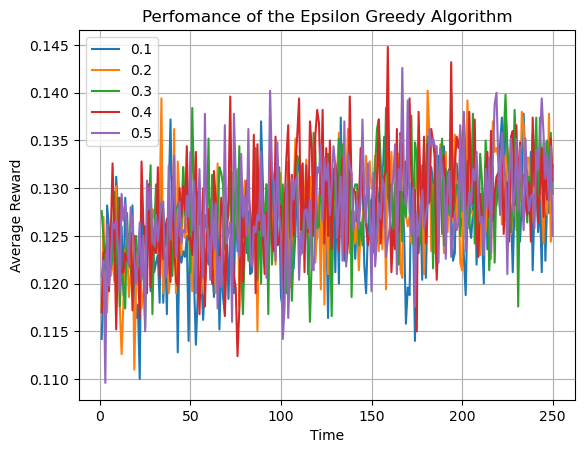

In [16]:
plt.plot(kk['times'][kk['epsilon'] == 0.1], kk['rewards'][kk['epsilon'] == 0.1], label='0.1')
plt.plot(kk['times'][kk['epsilon'] == 0.2], kk['rewards'][kk['epsilon'] == 0.2], label='0.2')
plt.plot(kk['times'][kk['epsilon'] == 0.3], kk['rewards'][kk['epsilon'] == 0.3], label='0.3')
plt.plot(kk['times'][kk['epsilon'] == 0.4], kk['rewards'][kk['epsilon'] == 0.4], label='0.4')
plt.plot(kk['times'][kk['epsilon'] == 0.5], kk['rewards'][kk['epsilon'] == 0.5], label='0.5')
plt.xlabel('Time')
plt.ylabel('Average Reward')
plt.title('Perfomance of the Epsilon Greedy Algorithm')
plt.legend()
plt.grid()
plt.show()

В данном конкретном случае результаты довольно похожи, потому что (A) награды находятся на таком большом расстоянии друг от друга и потому что (B) все награды равны 0 или 1. Но в других условиях эти показатели могут отличаться гораздо сильнее.

## Подход 3: отслеживание совокупного вознаграждения в каждый момент времени

В конечном счете, в обоих рассмотренных подходах есть один недостаток: они слишком узко сфокусированы на производительности алгоритма в каждый фиксированный момент времени и не дают нам картины производительности алгоритма на протяжении всей жизни. Этот близорукий фокус на каждой точке времени в отдельности несправедлив к версиям алгоритма epsilon-Greedy, в которых epsilon велик, потому что эти алгоритмы, по определению, исследуют худшие варианты чаще, чем алгоритмы, для которых epsilon мал. Это жертва, на которую они намеренно идут, чтобы исследовать быстрее. Чтобы решить, стоит ли такое увеличение скорости поиска проблем, мы должны сосредоточиться не на производительности алгоритма в какой-то конкретный момент времени, а на его совокупной производительности с течением времени.

Для этого мы можем проанализировать кумулятивную награду наших алгоритмов, которая представляет собой просто общую сумму вознаграждения, которую алгоритм выиграл для нас до некоторого фиксированного момента времени. Кумулятивная награда важна, потому что она более справедливо относится к алгоритмам, которые проводят много исследований на начальном этапе как средство поиска наилучшей доступной руки. Как видно на рисунке ниже, анализ на основе кумулятивного вознаграждения приводит к гораздо более чистой оценке эффективности различных значений epsilon, которые мы тестировали.

In [17]:
kk = df.groupby(['epsilon', 'times']).mean().reset_index()

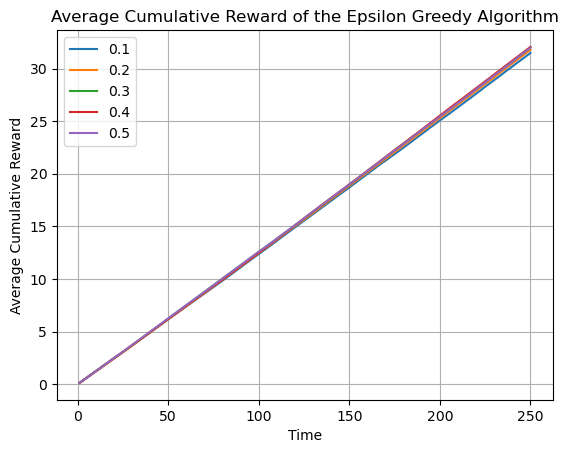

In [18]:
plt.plot(kk['times'][kk['epsilon'] == 0.1], kk['cumulative_rewards'][kk['epsilon'] == 0.1], label='0.1')
plt.plot(kk['times'][kk['epsilon'] == 0.2], kk['cumulative_rewards'][kk['epsilon'] == 0.2], label='0.2')
plt.plot(kk['times'][kk['epsilon'] == 0.3], kk['cumulative_rewards'][kk['epsilon'] == 0.3], label='0.3')
plt.plot(kk['times'][kk['epsilon'] == 0.4], kk['cumulative_rewards'][kk['epsilon'] == 0.4], label='0.4')
plt.plot(kk['times'][kk['epsilon'] == 0.5], kk['cumulative_rewards'][kk['epsilon'] == 0.5], label='0.5')
plt.xlabel('Time')
plt.ylabel('Average Cumulative Reward')
plt.title('Average Cumulative Reward of the Epsilon Greedy Algorithm')
plt.legend()
plt.grid()
plt.show()

На самом деле, если посмотреть на кумулятивные результаты, то можно увидеть, что кривые для низкого значения epsilon = 0,1 и высокого значения epsilon = 0,5 пересекаются примерно через 130 раундов: до этого момента хорошо было исследовать много, но после этого лучше иметь возможность больше эксплуатировать, когда алгоритм нашел лучшую руку.

Тем не менее, все наши нрафики передают одну и ту же основную мысль: алгоритм epsilon-Greedy в конечном итоге определяет, какая рука лучше, независимо от того, как задан epsilon. Но время, необходимое для того, чтобы определить, какая рука лучше, во многом зависит от значения epsilon.

То, что подходит именно вам, зависит от того, как долго вы собираетесь запускать свой алгоритм и насколько разными будут тестируемые руки. Чтобы понять, как алгоритм epsilon-Greedy может вести себя на вашем сайте, воспользуйтесь нашей системой тестирования, чтобы смоделировать типы показателей кликов, которые вы привыкли видеть.

## Упражнения

Чтобы по-настоящему понять алгоритм epsilon-Greedy, нужно посмотреть, как он как он ведет себя в различных обстоятельствах. Для этого вам следует попробовать выполнить следующие Упражнения:
- Используйте количество рук, отличное от пяти, с которыми мы работали. Посмотрите на сайте как ведет себя epsilon-Greedy при наличии 2 рук, а затем посмотрите, как он ведет себя при наличии 200 рук.
- Измените вероятности вознаграждения в руках Бернулли. 
    - Как будет вести себя эпсилон-Greedy, если все вероятности близки к 0,0? 
    - Как она поведет себя, если все вероятности близки к 1,0? 
    - Как он ведет себя, если вероятности для для разных рук одинаковы? 
    - Как она ведет себя, когда они далеки друг от друга?
    
После того как вы увидите, как ведет себя стандартный алгоритм epsilon-Greedy, мы также рекомендуем вам вам поэкспериментировать и попробовать модифицировать epsilon-Greedy, чтобы он стал немного лучше. 

На сайте есть два особых трюка, которые стоит изучить:
- Измените правила инициализации для полей значений. Вместо предположения, что каждая рука имеет значение 0.0 (что равносильно крайнему пессимизму в отношении незнакомых рук), попробуйте предположить, что каждая рука имеет значение 1.0 в начале. Как это изменит поведение алгоритма на разных задачах?
- Постройте модифицированную версию алгоритма epsilon-Greedy, которая может изменять значение epsilon с течением времени, так что epsilon будет высоким в начале и низким в конце симуляции. Такой переход от большого количества исследований к малому называется отжигом и будет рассмотрен в следующей главе. Реализация отжига для алгоритма epsilon-Greedy особенно информативна в отношении слабых мест стандартного алгоритма epsilon-Greedy.
- Более сложная задача, над которой вы можете поработать, - это разработать альтернативный тест для оценки эффективности алгоритма epsilon-Greedy. В этом альтернативном тесте вы должны отслеживать работу алгоритма только в тех случаях, когда он пытается использовать преимущества. Это потребует от вас хранения большего количества информации во время каждой симуляции, чем мы храним сейчас, но это может помочь вам создать интуицию о том, как ведет себя алгоритм epsilon-Greedy.

# AnnealingEpsilonGreedy

In [19]:
import random
import math

def ind_max(x):
    m = max(x)
    return x.index(m)

class AnnealingEpsilonGreedy:
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values

    def initialize(self, n_arms):
        self.counts = [0 for col in range(n_arms)]
        self.values = [0.0 for col in range(n_arms)]
        return

    def select_arm(self):
        t = sum(self.counts) + 1
        epsilon = 1 / math.log(t + 0.0000001)
    
        if random.random() > epsilon:
            return ind_max(self.values)
        else:
            return random.randrange(len(self.values))
  
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm]

        value = self.values[chosen_arm]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        self.values[chosen_arm] = new_value

In [20]:
import random

random.seed(1)
means = [0.1, 0.12, 0.15]
n_arms = len(means)
random.shuffle(means)
arms = list(map(lambda mu: BernoulliArm(mu), means))
print("Best arm is " + str(ind_max(means)))

my_algo = AnnealingEpsilonGreedy([], [])
my_algo.initialize(n_arms)
results = test_algorithm(my_algo, arms, 5000, 250)

f = open("epsilon_greedy_annealing_results.tsv", "w")

for i in range(len(results[0])):
    f.write("\t".join([str(results[j][i]) for j in range(len(results))]) + "\n")

f.close()

Best arm is 1


In [21]:
df = pd.read_csv('epsilon_greedy_annealing_results.tsv', sep='\t', header=None)
df.columns = ['sim_nums', 'times', 'chosen_arms', 'rewards', 'cumulative_rewards']

## Подход 1: отслеживание вероятности выбора лучшей руки

In [22]:
kk = df[(df['chosen_arms']==1)].groupby(['times', 'chosen_arms']).size().reset_index()
kk.columns = ['times', 'chosen_arms', 'count']
kk['proba'] = kk['count']/5000

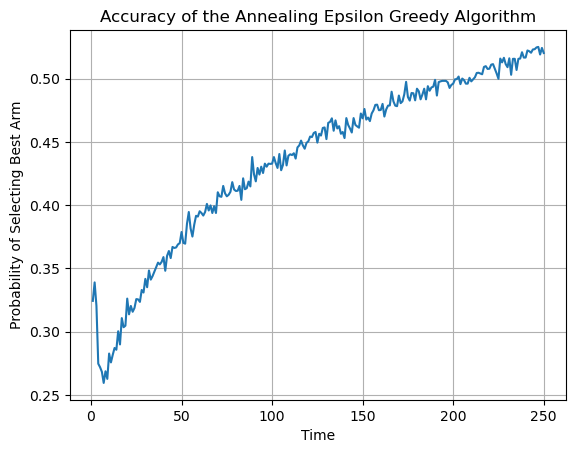

In [23]:
plt.plot(kk['times'], kk['proba'])

plt.xlabel('Time')
plt.ylabel('Probability of Selecting Best Arm')
plt.title('Accuracy of the Annealing Epsilon Greedy Algorithm')

plt.grid()
plt.show()

## Подход 2: отслеживание среднего вознаграждения в каждый момент времени

In [24]:
kk = df.groupby(['times']).mean().reset_index()

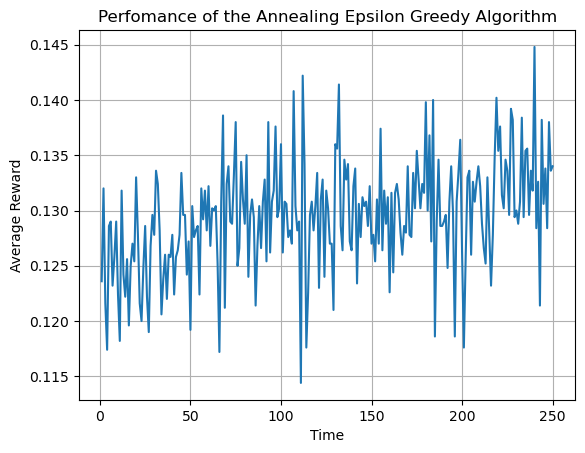

In [25]:
plt.plot(kk['times'], kk['rewards'])

plt.xlabel('Time')
plt.ylabel('Average Reward')
plt.title('Perfomance of the Annealing Epsilon Greedy Algorithm')

plt.grid()
plt.show()

## Подход 3: отслеживание совокупного вознаграждения в каждый момент времени

In [26]:
kk = df.groupby(['times']).mean().reset_index()

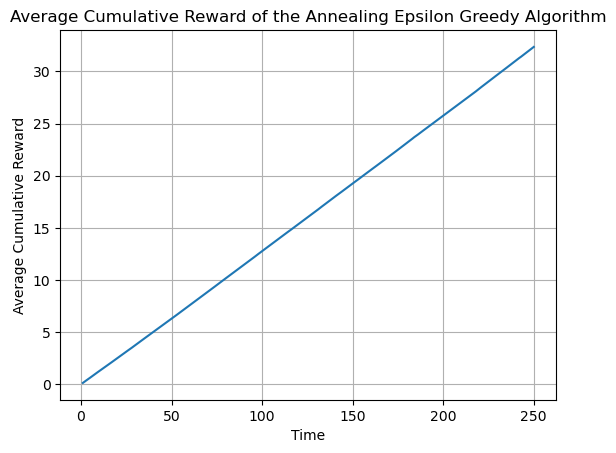

In [27]:
plt.plot(kk['times'], kk['cumulative_rewards'])

plt.xlabel('Time')
plt.ylabel('Average Cumulative Reward')
plt.title('Average Cumulative Reward of the Annealing Epsilon Greedy Algorithm')

plt.grid()
plt.show()